In [209]:
import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import glob
import numpy as np
import random
import itertools
from collections import Counter

# import nltk
# from nltk.corpus import stopwords
# from nltk.tokenize import word_tokenize
# nltk.download('punkt')

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [200]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

In [21]:
bbc_sport_dir = 'bbcsport/'
sport_categories = {
    0: 'athletics',
    1: 'cricket',
    2: 'football',
    3: 'rugby',
    4: 'tennis'
}

sport_text_and_label = []

for idx, label in sport_categories.items():    
    for file_name in glob.glob(bbc_sport_dir + label + '/*.txt'):
        with open(file_name, 'r', encoding='utf8', errors='ignore') as news_file:
            text = news_file.read()
            
#             text_tokenized = word_tokenize(text)
#             text_wo_stopword = [word for word in text_tokenized if not word in STOPWORDS]
            
#             text = ' '.join(text_wo_stopword)
            
        sport_text_and_label.append([text, idx])
        
random.shuffle(sport_text_and_label)

In [46]:
# print counts by category from Counter
def show_counts(labels):
    
    # Count total number of each label
    counter = Counter(l for l in labels)
    counter = sorted(counter.items())
    
    print('Document Counts by Category:')
    
    for label, count in counter:
        cat = sport_categories.get(label)
        print("'{}': {}".format(cat, count))

In [47]:
# Shuffle documents for random sampling
random.shuffle(sport_text_and_label)

# Seperate text and label into two lists
sport_text = [text[0] for text in sport_text_and_label]
sport_label = [label[1] for label in sport_text_and_label]

# Take the first 200 documents as imbalence sample
sample_text = sport_text[:200]
sample_label = sport_label[:200]

# Remaining text and label for model trainning
remain_text = sport_text[200:]
remain_label = sport_label[200:]

In [158]:
print("Total Numbers of Sport Documents: {}".format(len(sport_text_and_label)))
show_counts(sport_label)

print("\nNumbers of Documents in Imbalence Sample: {}".format(len(sample_text)))
show_counts(sample_label)

print("\nNumbers of Documents in Remaining Data: {}".format(len(remain_text)))
show_counts(remain_label)

Total Numbers of Sport Documents: 737
Document Counts by Category:
'athletics': 101
'cricket': 124
'football': 265
'rugby': 147
'tennis': 100

Numbers of Documents in Imbalence Sample: 200
Document Counts by Category:
'athletics': 28
'cricket': 35
'football': 73
'rugby': 39
'tennis': 25

Numbers of Documents in Remaining Data: 537
Document Counts by Category:
'athletics': 73
'cricket': 89
'football': 192
'rugby': 108
'tennis': 75


In [159]:
# Create tokenizer for vectorizing documents, using the top 3000 most common words only
tokenizer = Tokenizer(num_words=3000, oov_token='<oov>')

# Updates internal vocabulary based on the BBC Sport Documents
tokenizer.fit_on_texts(sport_text)

# Transform each document into sequence
sport_seq = tokenizer.texts_to_sequences(remain_text)
sample_seq = tokenizer.texts_to_sequences(sample_text)

# Use padding to ensure each sequence has the same length
sport_pad = pad_sequences(sport_seq, maxlen=300, padding='post', truncating='post')
sample_pad = pad_sequences(sample_seq, maxlen=300, padding='post', truncating='post')

sport_labels = np.array(remain_label)
sport_labels = sport_labels.reshape(537, 1)

sample_labels = np.array(sample_label)
sample_labels = sample_labels.reshape(200, 1)

In [160]:
# Use RNN model to train on the remaining documents

sport_model = tf.keras.Sequential([
    tf.keras.layers.Embedding(3000, 128),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(5, activation='softmax')
])

sport_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

sport_model.fit(sport_pad, sport_labels, epochs=10)

Epoch 1/10
17/17 [==============================] - 7s 417ms/step - loss: 1.5668 - accuracy: 0.3222
Epoch 2/10
17/17 [==============================] - 7s 418ms/step - loss: 1.3893 - accuracy: 0.3948
Epoch 3/10
17/17 [==============================] - 7s 405ms/step - loss: 1.0608 - accuracy: 0.5736
Epoch 4/10
17/17 [==============================] - 7s 413ms/step - loss: 0.6726 - accuracy: 0.6927
Epoch 5/10
17/17 [==============================] - 7s 416ms/step - loss: 0.4742 - accuracy: 0.7765
Epoch 6/10
17/17 [==============================] - 7s 425ms/step - loss: 0.2853 - accuracy: 0.8939
Epoch 7/10
17/17 [==============================] - 7s 423ms/step - loss: 0.2741 - accuracy: 0.9013
Epoch 8/10
17/17 [==============================] - 7s 431ms/step - loss: 0.1759 - accuracy: 0.9572
Epoch 9/10
17/17 [==============================] - 7s 435ms/step - loss: 0.0676 - accuracy: 0.9870
Epoch 10/10
17/17 [==============================] - 9s 545ms/step - loss: 0.0303 - accuracy: 1.0000

In [161]:
# Extract the embedding layer after trainning
embeddings = sport_model.get_weights()[0]
embeddings[0]

array([ 0.03970812,  0.02908466,  0.03333494, -0.0101711 ,  0.00564744,
       -0.02620706,  0.03463423, -0.00756285, -0.01489437,  0.01975469,
       -0.02284447,  0.01290791,  0.00357499,  0.0477842 ,  0.01057516,
        0.04557753,  0.00519349, -0.02454812,  0.00593441,  0.00628791,
       -0.03317672, -0.04989831,  0.02686261,  0.01960651,  0.00478452,
        0.04962315, -0.01871899, -0.02893814,  0.00946735, -0.04306687,
        0.00501858, -0.00866182,  0.04513465,  0.01910175, -0.02413565,
        0.01292916,  0.01217696,  0.03154708,  0.04736695, -0.03634891,
       -0.01306374, -0.04367368,  0.03303039,  0.03768586,  0.0516513 ,
        0.0348365 , -0.00242463, -0.01599496, -0.02800912, -0.02331621,
       -0.01241264,  0.02232088, -0.00499808,  0.00802732,  0.0217566 ,
       -0.0030213 , -0.03722651, -0.03848151, -0.00721921, -0.03630155,
        0.00655006,  0.01966248,  0.0317475 ,  0.04275903, -0.03122938,
       -0.01896047,  0.01321741,  0.0205774 ,  0.02021072, -0.01

In [162]:
# Get the first 3000 most common word index from the tokenizer
word_to_idx = dict(itertools.islice(tokenizer.word_index.items(), 3000))

In [163]:
# Assign the trained embedding to each word
words_embeddings = {word : embeddings[idx - 1] for word, idx in word_to_idx.items()}

In [164]:
# Create the embedding matrix from the trained word embedding
embedding_matrix = np.zeros((3000, 128))
for word, index in word_to_idx.items():
    embedding_vector = words_embeddings.get(word)
    embedding_matrix[index - 1] = embedding_vector

In [165]:
embedding_matrix

array([[ 0.03970812,  0.02908466,  0.03333494, ...,  0.02315169,
        -0.0356619 ,  0.04094306],
       [ 0.02051874,  0.00021923, -0.01816545, ...,  0.03631048,
         0.00024863, -0.03891807],
       [-0.01593504,  0.02793613, -0.02777778, ..., -0.03362621,
        -0.04151076,  0.00409347],
       ...,
       [-0.02050825, -0.02932316, -0.04656348, ...,  0.02160077,
         0.02468301, -0.0257545 ],
       [-0.02119808, -0.04107793, -0.03644225, ...,  0.02003489,
         0.00372635, -0.02836842],
       [ 0.04535027,  0.00591978, -0.00635319, ...,  0.01080028,
        -0.02650995, -0.00765422]])

In [276]:
glove = open('glove/glove.6B.100d.txt', encoding='utf8')

embeddings_dict = dict()

for line in glove:
    records = line.split()
    word = records[0]
    vector_dimensions = np.asarray(records[1:], dtype='float32')
    embeddings_dict[word] = vector_dimensions

glove.close()

embeddings_dict = dict(itertools.islice(embeddings_dict.items(), 3000))

glove_embedding_matrix = np.zeros((3000, 100))
for word, index in word_to_idx.items():
    embedding_vector = embeddings_dict.get(word)
    if embedding_vector is not None:
        glove_embedding_matrix[index - 1] = embedding_vector

In [250]:
def get_samples(sample_size=200):
    # Shuffle documents for random sampling
    random.shuffle(sport_text_and_label)

    # Seperate text and label into two lists
    sport_text = [text[0] for text in sport_text_and_label]
    sport_label = [label[1] for label in sport_text_and_label]

    # Take the first 200 documents as imbalence sample
    sample_text = sport_text[:sample_size]
    sample_label = sport_label[:sample_size]

#     print("\nNumbers of Documents in Imbalence Sample: {}".format(len(sample_text)))
#     show_counts(sample_label)
    
#     Split the sample data into train, test and validation set
    sample_train_text, sample_test_text, sample_train_label, sample_test_label = train_test_split(
            sample_text, sample_label, test_size=0.2
    )
    train_size = len(sample_train_text)
    test_size = len(sample_test_text)

    # Transform each document into sequence
    sample_train_seq = tokenizer.texts_to_sequences(sample_train_text)
    sample_test_seq = tokenizer.texts_to_sequences(sample_test_text)

    # Use padding to ensure each sequence has the same length
    sample_train_pad = pad_sequences(sample_train_seq, maxlen=300, padding='post', truncating='post')
    sample_test_pad = pad_sequences(sample_test_seq, maxlen=300, padding='post', truncating='post')
    
    sample_train_label = np.array(sample_train_label)
    sample_train_label = sample_train_label.reshape(train_size, 1)
    
    sample_test_label = np.array(sample_test_label)
    sample_test_label = sample_test_label.reshape(test_size, 1)
    
    return sample_train_pad, sample_train_label, sample_test_pad, sample_test_label


In [279]:
'''
After retriving the pre-trained embedding, we take random sample from the sport text,
for each sample, we split it into train, test set (0.8,0.2) and fit into a model
with pre-trained embedding (the embedding layer is freezed, not trainable).

With different training epochs (start from 1 epoch) to train the model,
we take different random sample size and plot out each training and testing accuracy

    eg. at loop with epoch = 3, size = 200, 
        we take sample size of 200 documents and split them into train, test set,
        build the model with pre-trained embedding with epoch = 3 to train on the sample data,
        then plot out the final training accuracy and testing accuracy
'''
def bbcsport_transfer_learning(embedding_matrix, emb_dim):
    # Training epoch
    for epoch in range(1, 6):
        record = []
        for size in range(20, 300, 5):

            # Get sample for trainning and testing
            sample_train_pad, sample_train_label, sample_test_pad, sample_test_label = get_samples(size)

            # Create embedding layer based on the pre=trained embedding
            embedding_layer = tf.keras.layers.Embedding(3000, emb_dim, 
                                          embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix), 
                                          input_length=300)
            embedding_layer.trainable = False

            # Create model for testing the sample documents based on the pre-trained embedding
            trained_model = tf.keras.Sequential([
                embedding_layer,
                tf.keras.layers.Flatten(),
                tf.keras.layers.Dense(5, activation='softmax')
            ])

            trained_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

            history = trained_model.fit(sample_train_pad, sample_train_label, epochs=epoch, verbose=0)
            loss, test_accuracy = trained_model.evaluate(sample_test_pad, sample_test_label, verbose=0)
            # predictions = trained_model.predict_classes(sample_test_pad)
            # tf.math.confusion_matrix(sample_test_label, predictions, num_classes=5)

            # Record trainning accuracy (last epoch) and testing accuracy
            record.append((history.history['accuracy'][-1], test_accuracy))

        fig = plt.figure()
        plt.plot(range(20, 300, 5), [train_acc for train_acc, test_acc in record], label='Train Accuracy')
        plt.plot(range(20, 300, 5), [test_acc for train_acc, test_acc in record], label='Test Accuracy')
        plt.legend()
        plt.title('Epoch Numbers: {}'.format(epoch))
        plt.xlabel('Number of Documents')
        plt.ylabel('Accuracy')
        plt.show()

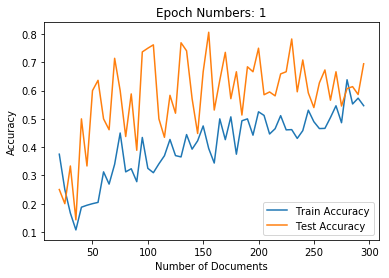

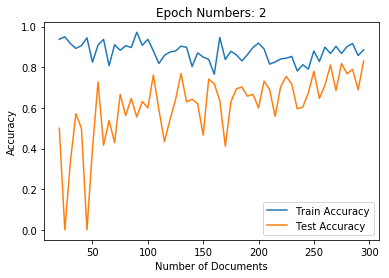

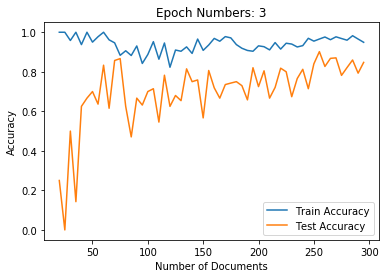

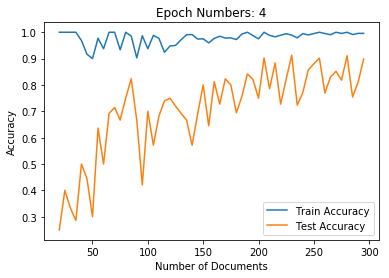

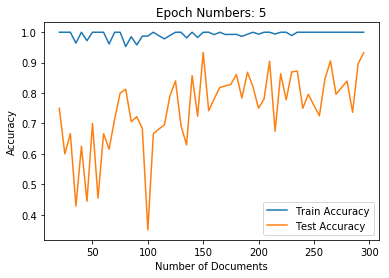

In [280]:
# Using pre-trained embedding from trainning the BBC Sport Documents
bbcsport_transfer_learning(embedding_matrix, 128)

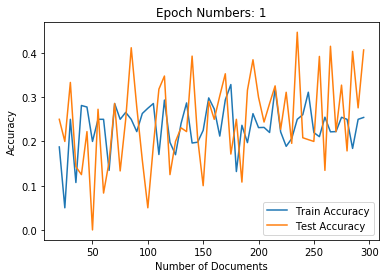

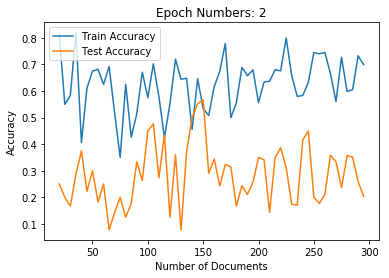

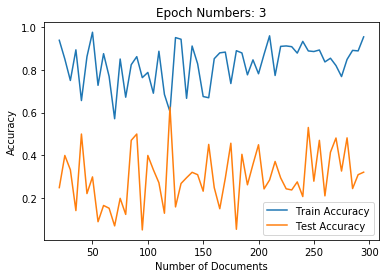

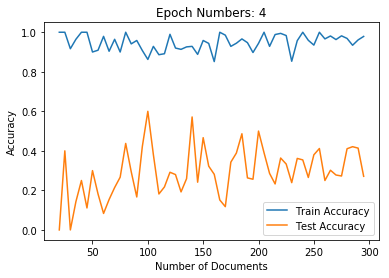

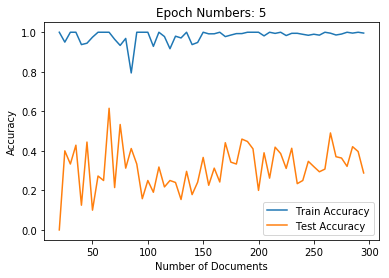

In [281]:
# Using pre-trained embedding from GloVe (Global Vectors for Word Representation) 
# https://nlp.stanford.edu/projects/glove/
bbcsport_transfer_learning(glove_embedding_matrix, 100)